In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools

Загрузим данные

In [2]:
df = pd.read_csv("SAMPL.csv")
df.head()

,iupac,smiles,expt,calc
0,"4-methoxy-N,N-dimethyl-benzamide",CN(C)C(=O)c1ccc(cc1)OC,-11.01,-9.625
1,methanesulfonyl chloride,CS(=O)(=O)Cl,-4.87,-6.219
2,3-methylbut-1-ene,CC(C)C=C,1.83,2.452
3,2-ethylpyrazine,CCc1cnccn1,-5.45,-5.809
4,heptan-1-ol,CCCCCCCO,-4.21,-2.917


Прочитаем SMILES

,smiles,Molecule
0,CN(C)C(=O)c1ccc(cc1)OC,

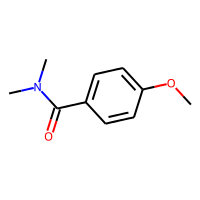

In [3]:
PandasTools.AddMoleculeColumnToFrame(df, "smiles", "Molecule")
df[["smiles", "Molecule"]].head(1)

Приведем к формату для pytorch-geometric.

In [4]:
from engine.utils import rdkit_to_pyg

PandasTools.AddMoleculeColumnToFrame(df, "smiles", "Molecule")
data = [rdkit_to_pyg(mol, expt) for mol, expt in df[["Molecule", "expt"]].values]

Создадим модель. Возьмем для начала размерность 8 для эмбеддингов и 16 для скрытых фич. По умолчанию стоит 2 сверточных слоя.

In [5]:
from engine.model import GCN

model = GCN(8,8,16,1)

Обучим. 

In [6]:
from train import train_network

training_module = train_network(model, data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 2.4 K 
-------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 148.33it/s, loss=1.72, v_num=53]


In [7]:
def print_best_metrics(metrics):
    print(f"Финальные тестовые метрики: {min(metrics, key=lambda x: x['MSE'])}")
    print(f"С лучшим R2: {max(metrics, key=lambda x: x['R2'])}")

In [8]:
print_best_metrics(training_module.validation_metrics)

Финальные тестовые метрики: {'MSE': 2.9513571990094336, 'R2': 0.7720388530681129}
С лучшим R2: {'MSE': 2.9513571990094336, 'R2': 0.7720388530681129}


Попробуем другие параметры.

In [9]:
# Больше внтуренних фичей

model = GCN(8,8,32,1)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 3.9 K 
-------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 163.41it/s, loss=1.4, v_num=54]
Финальные тестовые метрики: {'MSE': 1.7718639740159319, 'R2': 0.8441130000195272}
С лучшим R2: {'MSE': 1.7718639740159319, 'R2': 0.8441130000195272}


In [10]:
# Добавим скрытых слоев

model = GCN(8,8,16,1, n_inner_layers=2)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 7.6 K 
-------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 135.02it/s, loss=0.419, v_num=55]
Финальные тестовые метрики: {'MSE': 1.4961933869588668, 'R2': 0.9161689502666052}
С лучшим R2: {'MSE': 1.4961933869588668, 'R2': 0.9161689502666052}


In [11]:
# Добавим скрытых слоев

model = GCN(8,8,32,1, n_inner_layers=2)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 24.4 K
-------------------------------
24.4 K    Trainable params
0         Non-trainable params
24.4 K    Total params
0.098     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 126.02it/s, loss=1.17, v_num=56]
Финальные тестовые метрики: {'MSE': 2.5304809378328774, 'R2': 0.7818665351921001}
С лучшим R2: {'MSE': 2.5304809378328774, 'R2': 0.7818665351921001}


In [12]:
# Меньше скрытый слой

model = GCN(8,8,8,1)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 1.7 K 
-------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 158.96it/s, loss=1.47, v_num=57]
Финальные тестовые метрики: {'MSE': 1.469142256950387, 'R2': 0.9074654479203478}
С лучшим R2: {'MSE': 1.469142256950387, 'R2': 0.9074654479203478}


In [13]:
# Больше эмбеддинги

model = GCN(16,16,16,1)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 6.9 K 
-------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 161.28it/s, loss=1.34, v_num=58]
Финальные тестовые метрики: {'MSE': 2.677706746611904, 'R2': 0.7988261236321198}
С лучшим R2: {'MSE': 2.677706746611904, 'R2': 0.7988261236321198}


In [14]:
# Меньше эмбеддинги

model = GCN(4,4,16,1)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 989   
-------------------------------
989       Trainable params
0         Non-trainable params
989       Total params
0.004     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 163.37it/s, loss=1.37, v_num=59]
Финальные тестовые метрики: {'MSE': 2.451496706301103, 'R2': 0.8538206636592992}
С лучшим R2: {'MSE': 2.451496706301103, 'R2': 0.8538206636592992}


In [15]:
# Больше всего

model = GCN(16,16,32,1)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 11.8 K
-------------------------------
11.8 K    Trainable params
0         Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 167.75it/s, loss=1.41, v_num=60]
Финальные тестовые метрики: {'MSE': 2.9798934504358323, 'R2': 0.8608372671475074}
С лучшим R2: {'MSE': 2.9798934504358323, 'R2': 0.8608372671475074}


In [16]:
model = GCN(8, 8, 8, 1, n_inner_layers=2)
training_module = train_network(model, data)
print_best_metrics(training_module.validation_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | GCN  | 3.0 K 
-------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total params
0.012     Total estimated model params size (MB)


/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dumtrii/Documents/practos/spring3/bio/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (19) is smaller than

Epoch 999: 100%|██████████| 22/22 [00:00<00:00, 123.15it/s, loss=0.596, v_num=61]
Финальные тестовые метрики: {'MSE': 3.478739736771394, 'R2': 0.7354332295126922}
С лучшим R2: {'MSE': 3.478739736771394, 'R2': 0.7354332295126922}


Будем считать, что победила эта конфигурация, хотя от запуска к запуску результат немного менялся. Еще надо попробовать разные параметры обучения, дропаут и прочее, но, наверное, этого пока хватит. 


Получается: MSE: 1.4961933869588668, R2: 0.9161689502666052.

In [ ]:
GCN(8,8,16,1, n_inner_layers=2)